In [1]:
from math import factorial, pi
from matplotlib import pyplot as plt
import numpy as np

def dot(x, y):
    if len(x) != len(y):
        raise Exception('Sizes missmatch')
    return sum([i * j for i, j in zip(x, y)])

def relu(x):
    return max(0, x)


class Neuron:
    def __init__(self, w, b):
        self.w = w
        self.b = b
    def __call__(self, x):
        if len(x) != len(self.w):
            raise Exception('Sizes missmatch')
        return relu(dot(self.w, x) + self.b)
    
    
# block of 3 neurons that implement function g
class BlockG:
    w = [2, -4, 2]
    b = [0, -0.5, -1]
    def __init__(self):
        pass

    def __call__(self, x):
        #print(args)
        if len(x) == 1:
            n = x[0]
        elif len(x) == 3:
            n = dot(self.w, x)
        return [relu(n + bs) for bs in self.b]


# block of neurons for x ** 2 function approximation
# N = 3 * m + 3 * (m - 1) * 3 + 4 = 12m - 5 connections inside a block 
class BlockX2:
    def __init__(self, m):
        self.m = m
        self.g_weights = [1] + [- 1 / 2 ** (2 * i) for i in range(1, m + 1)]
        #print(self.g_weights)

    def __call__(self, x):
        pre_res_vec = [x]
        for m in range(len(self.g_weights) - 1):
            if not m: 
                prev_out = [x]
            prev_out = BlockG()(prev_out)
            pre_res_vec.append(dot(prev_out, [2, -4, 2]))
        #print(pre_res_vec)
        return dot(pre_res_vec, self.g_weights)
    

# block of neurons for x * y function approximation
# M = 3 + 4 + N + 3 + N = 2N + 10 = 24m connections
class BlockXY:
    def __init__(self, x2_m):
        self.x2_m = x2_m
        
    def __call__(self, x, y):
        #print(BlockX2(self.x2_m)(x + y))
        #print(BlockX2(self.x2_m)(BlockABS()(x - y)))
        return BlockX2(self.x2_m)(0.5 * (x + y)) - BlockX2(self.x2_m)(BlockABS()(0.5 * (x - y)))

    
# block of neurons for Taylor series approximation of sin(pi * x) for x \in [0, 1]
# T = 2 + n_power // 2 * 3 + N + M * (n_power // 2) = (24m + 3) * (n_power // 2) + 12m - 3 connections
class TaylorSine:
    def __init__(self, n_power, x2_m):
        self.n_power = n_power
        self.taylor_weights = [(-1) ** ((i - 1) % 4 / 2) * pi ** i / factorial(i) for i in range(1, n_power + 1, 2)]
        #print(self.taylor_weights)
        
        self.x2_m = x2_m
        
    def __call__(self, x):
        x_squared = BlockX2(self.x2_m)(x)
        #print(x_squared)
        pre_res_vec = [x]
        for i in range(len(self.taylor_weights) - 1):
            if i:
                prev_out = pre_res_vec[i]
            else:
                prev_out = x
            #print('prev_out: {}\ncurrent mult: {}'.format(prev_out, BlockXY(self.x2_m)(x_squared, prev_out)))
            pre_res_vec.append(BlockXY(self.x2_m)(x_squared, prev_out))
        return dot(pre_res_vec, self.taylor_weights)

In [2]:
# block of neurons to calculate the absolute value
# 4 connections inside this block
class BlockABS:
    def __init__(self):
        self.neurons = [Neuron([1], 0), Neuron([-1], 0)]
        self.abs_neuron = Neuron([1, 1], 0)
    def __call__(self, x):
        return relu(self.abs_neuron([relu(neuron([x])) for neuron in self.neurons]))

In [3]:
class BlockIndicator:
    def __init__(self):
        self.n1 = Neuron([1], 1)
        self.n2 = Neuron([1], 0)
        self.n3 = Neuron([1, -1], 0)
        self.n4 = Neuron([2], -1)
    def __call__(self, x):
        return relu(self.n4([relu(self.n3([relu(self.n1([x])), relu(self.n2([x]))]))]))

In [4]:
# block of neurons that maps [-pi, pi] to [0, 1]
# 4 + 1 = 5 connections
class BlockNorm:
    def __init__(self):
        self.n1 = Neuron([1 / pi], 0)
    def __call__(self, x):
        return relu(self.n1([BlockABS()(x)]
                           ))

## Total number of connections:
5 in BlockNorm + (24m + 3) * (n_power // 2) + 12m - 3 in TaylorSine. (See class descriptions for more details)


In [5]:
n_connections = lambda m, n_power: 5 + (24 * m + 3) * (n_power // 2) + 12 * m - 3

In [6]:
n_connections(22, 23)

6107

## Fianl approximation and error estimation

In [7]:
net = TaylorSine(23, 20)

In [8]:
from math import sin
from numpy import linspace
from matplotlib import pyplot as plt

n = 10000
x = linspace(0, pi, n)
y = [net(BlockNorm()(point)) for point in x] 
sin_y = [sin(point) for point in x]

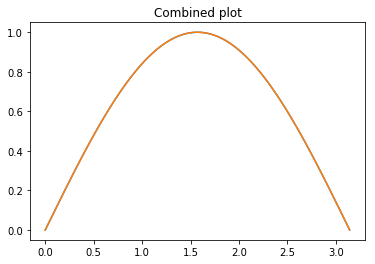

In [9]:
plt.plot(x, y)
plt.plot(x, sin_y)
plt.title('Combined plot')
plt.show()


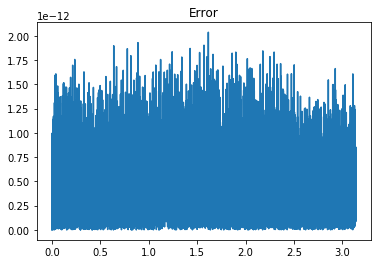

In [10]:
plt.plot(x, [abs(i-j) for i, j in zip(y, sin_y)])
plt.title('Error')
plt.show()

In [11]:
def uniform_error(net, linspace):
    mx = 0
    ind = 0
    for point in linspace:
        y = net(BlockNorm()(point))
        sin_y = sin(point)
        v = abs(y - sin_y)
        if  v > mx:
            mx = v
            ind = point
    return mx

print('Final uniform error:', uniform_error(net, x))


Final uniform error: 2.0362600494649996e-12
